<a href="https://colab.research.google.com/github/san2103/Dog-breed-vision/blob/main/doggo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

End to End Multi-class Dog Breed Classification
#1. Problem:
 Identify breed of a dog by given an image of dog.
#2.Data: 
The data is from Kaggle's dog breed identification competition.
"https://www.kaggle.com/competitions/dog-breed-identification/data"
#3.Evaluation:
The evaluation is a file with prediction probablities for each dog breed of each test image.
#4. Features:
We're dealing with images(unstructrured Data) so it's best use deep learning/transfer learning.
There are 120 breeds of dogs( this means there are 120 different classes).
Around 10000 + images in training set(have labels)
Around 10000+ images in test set(without labels




In [ ]:

#!unzip "drive/MyDrive/dog vision/dog-breed-identification.zip" -d "drive/MyDrive/dog vision/"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
#print(tf.__version__)
#print(hub.__version__)
#print(tf.config.list_physical_devices("GPU"))

Turning images into Tensors(numerical representation(matrix/numpy array))

In [ ]:
import pandas as pd
label_csv=pd.read_csv("drive/MyDrive/dog vision/labels.csv")

In [ ]:
#label_csv.head()
#label_csv["breed"].value_counts().plot.bar(figsize=(40,20))


In [ ]:
#from IPython.display import Image
#Image("drive/MyDrive/dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

In [ ]:
#label_csv.head

In [ ]:
#filename=[fname for fname in label_csv["id"]]

In [ ]:
filename= [ "drive/MyDrive/dog vision/train/" + fname+".jpg" for fname in label_csv["id"] ]

In [ ]:
#filename[:5]

now we've got our trainning image filepaths in a list so we will prepare our labels.

In [ ]:
labels=label_csv["breed"]
import numpy as np
labels=np.array(labels)
#len(labels)
#labels
 

Find the unique label values and convert this array of strings into array of numbers


In [ ]:
unique_breeds=np.unique(labels) 
#unique_breeds  
#len(unique_breeds )  
     

In [ ]:
#print(labels[0])
#labels[0] == unique_breeds


In [ ]:
boolean_labels= [label == unique_breeds for label in labels]
#boolean_labels
#boolean_labels[:2]
#len(boolean_labels)

In [ ]:
print(np.where(unique_breeds == labels[0]))
#print(boolean_labels[0].astype(int))
#print(boolean_labels[0].argmax())


(array([19]),)


In [ ]:
x= filename
y=boolean_labels
#len(y)

In [ ]:
NUM_IMAGES =  1000 #@param {type: "slider", min:1000, max:10000, step:1000}

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val =train_test_split(x[:NUM_IMAGES], y[:NUM_IMAGES],test_size=0.2,random_state=42)

In [ ]:
len(X_train),len(Y_train),len(X_val),len(Y_val)

(800, 800, 200, 200)

In [ ]:
 #X_train[:5],Y_train[:2]

In [ ]:
#import cv2
#im=cv2.imread(filename[0])


## Preprocessing Image (turning images into Tensors)

In [ ]:
#convert an image to a numpy array
#from matplotlib.pyplot import imread
#image = imread(filename[2])
#image.shape

In [ ]:
#image[:2]

Turning image into Tensor


In [ ]:
#tf.constant(image)[:2]

##Function to preprocess image:
1. Take an image filepath as input
2.Use TensorFlow to read the file and save it to a variable, `image`
3. Resize the 'image' to be a shape(224,224)
4. Normalize our image(convert color channel values from 0-255 to 0-1)
5. Return the modified `image`

In [ ]:
#Define image size
IMG_SIZE = 224

In [ ]:
def process_image(image_path,img_size=IMG_SIZE):
 image = tf.io.read_file(image_path) # returns string tensor
 image = tf.image.decode_jpeg(image,channels =3) # converting image into numeric tensor
 #convert the colour channel values from 0-255 to 0-1 values
 image = tf.image.convert_image_dtype(image, tf.float32) #float
 image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE]) #resize image(244,244)
 return image
 

In [ ]:
#tensor1=tf.io.read_file(filename[0])
#tensor=tf.image.decode_jpeg(tensor1,channels=3)
#tensor

In [ ]:
#turning data in batches(because gpu has limitation over storage)
BATCH_SIZE = 32

In order to use TesnorFlow effectively, we need our data in the form of Tensor tuples which look like this:`(image, label)`

In [ ]:
#create a simple funcion to return a tuple (image, label) of tensor type
def get_image_label(image_path, label):
  """Takes an image filepath name and the associated label,
   processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label
  


In [ ]:
#demo 
#process_image(x[42], tf.constant (y[42]))

After getting a way turn our data into tuples of Tensors in the form:`(images, labels)`, lets's make a function to turn all of our data(`X` &`Y`) into batches.
function does the following:
 """ Creates batches of data out of image(X) and label (Y) pairs. Shuffles the data if it's training data but doesn't shuffle if it's validation data. Also accepts test data as input(no labels)"""


In [ ]:
#Creating Data batches Function 
#test has no labels
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
 if test_data:
  print("Creating test data batches...")
  data = tf.data.Dataset.from_tensor_slices(tf.constant(x)) #only filepaths(no labels)
  data_batch = data.map(process_image).batch(BATCH_SIZE)
  return data_batch
      #if the data is a valid dataset , we don't need to shuffle it
 elif valid_data:
   print("Creating validation data batches...")
   data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
   data_batch = data.map(get_image_label).batch(BATCH_SIZE)
   return data_batch

 else:
   print ("Creating training data batches...")
        #Turn filepaths and labels into Tensors
   data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
         
         #Shuffling pathnames and labels before mapping image processor is faster than shuffling images
   data = data.shuffle(buffer_size=len(x))
          #Create(image,label) tuples(this also turns the image path into a preprocessed image)
   data = data.map(get_image_label)
         #turn the trinnig data into batches
   data_batch = data.batch(BATCH_SIZE)
   return data_batch

In [ ]:
#Creating training and validation data batches
train_data = create_data_batches(X_train, Y_train)
val_data =   create_data_batches(X_val, Y_val, valid_data=True)
#len(Y_val)

Creating training data batches...
Creating validation data batches...


In [ ]:
#Creating out the different attributes of our data batches 
#train_data.element_spec, val_data.element_spec

Visualizing Data Batches
Our data is now in batches, however these can be a little hard to understand/comprehend,let's visualize them!

In [ ]:
from matplotlib import pyplot as plt
#create a function for viewing images in a data batch

In [ ]:
def show_25_images(images, labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax = plt.subplot(5,5,i+1)
    # create subplot (5 rows, 5 columns)
    plt.imshow(images[i])
    #Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")
    

In [ ]:
#train_images, train_labels = next(train_data.as_numpy_iterator())
#train_images, train_labels

In [ ]:
#show_25_images(train_images, train_labels)

In [ ]:
#val_images, val_labels= next(val_data.as_numpy_iterator())
#show_25_images(val_images, val_labels)

##Building a model

Before we build a model,there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image label, in the form of Tensors) of our model.
* The URL of the model we want to use.https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [ ]:
#Setup input shape to the  model
INPUT_SHAPE = [ None, IMG_SIZE, IMG_SIZE, 3] #batch ,height,width,colour channels
#setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)
#setup model URL from TensorFlow Hub 
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs ,outputs and model ready to go. let's put them together into a Keras deep learning model
function contains:
* Takes the input shape,output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first ,then this..)
* Compile the model (says it should be evaluated and improved)
* Buils the model (tells the model input shape it'll be getting)
* Returns the model
***when working with Binary classification- Activation function is `Sigmoid` and loss function is `Binary Crossentropy`, with Multi-class classsification - Activation function is `Softmax` and loss function is ` Catagorical Crossentropy` ***

In [ ]:
#create a functiojn which builds a Keras model
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
#setup the model layers
 model = tf.keras.Sequential( [hub.KerasLayer(MODEL_URL),#Layer 1 (input layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation ="softmax")])#Layer 2 (Output layer)
#compile the model
 model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

 #Build the model
 model.build(INPUT_SHAPE)
 return model

In [ ]:
model = create_model()
#model.summary()

##Creating callbacks 

Callbacks are helper functions a model can use to do such things as save its progress,check its progress or stop training early if a model stops improving

We will create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

##TensorBoard Callback

To steup a Tensoroard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it our model's `fit()` function.
3. Visualize our models training logs with the %tensorboard magic function(we will do this after model training).


In [ ]:
#Load TensorBoard notebook exension
%load_ext tensorboard

In [ ]:
import datetime
import os
#Create a function to build a TensorBoard callback 
def create_tensorboard_callback():
# Create a log directory for storing  TensorBoard logs
 logdir = os.path.join("drive/MyDrive/dog vision/logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) #Make it so the logs get tracked whenever we run experiment
 return tf.keras.callbacks.TensorBoard(logdir)
 

###Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation stops improving
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


In [ ]:
#Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)
#when accuracy stop going up for 3 epochs we stop training 

##Training a model (on subset of data)
Our first model is only going to train on 1000 images, to make sure everything is working 

!!Number of Epochs  how many passes of our data to model we want!! `In evey pass model will try to find the pattern in each dog image and see which patterns relates to each label`

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider",min:10, max:100}

##Ensure that  GPU is Working
print("GPU,"available(Yess)" if tf.config.list_physical_devices("GPU") else "not avialable")


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model



In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  #Create a model
  model = create_model()

  #Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  #Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data, epochs=NUM_EPOCHS,validation_data=val_data,
            validation_freq=1, callbacks=[tensorboard, early_stopping])
  #Return the fitted model
  return model


In [ ]:
# fit the model to the data
#model = train_model()

**Question:** It looks like our model is overfitting beacuse it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note**: Overfitting to beginwith is a good thing! It means our model is learning!!!

##Checking the TensorBoard logs
The TensorBorad magic function(`%tensorboard`) will access the logs dirctory the logs we created earlier and visualize it's contents.

In [ ]:
# %tensorboard --logdir drive/MyDrive/dog\ vision/logs

##Making and evaluating prediction using a trained model

In [ ]:
#Make prediction on the validation data(not used to train on )
#predictions = model.predict(val_data, verbose =1)
#predictions

In [ ]:
#predictions.shape

In [ ]:
#len(Y_val)
#len(unique_breeds)

In [ ]:
#predictions[0]
#len(predictions[0])
#np.sum(predictions[0])

In [ ]:
#First prediction
#index=0 
#print(predictions[0])
#print(f"Max value probabilty of prediction):{np.max(predictions[0])}")
#print(f"Sum: {np.sum(predictions[index])}")
#print(f"Max index:{np.argmax(predictions[index])}")
#print(f"Prediction label:{unique_breeds[np.argmax(predictions[index])]}")


In [ ]:
#unique_breeds[26]

Having the above functionality is great but we want to be able to do it at scale
And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities also known as confidence levels.

In [ ]:
#TUrn prediction probabilities into their respective label(eaier to understand )
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilties into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]
  #Get a predicted label based on an array of prediction probabilities 
#pred_label = get_pred_label(predictions[0])
#pred_label

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels(truth labels)

In [ ]:
#Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
  """
  images=[]
  labels=[]
#Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():    
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

#Unbatchify the validation data
#val_images, val_labels = unbatchify(val_data)
#val_images[0], val_labels[0]

In [ ]:
#get_pred_label(val_labels[0])

##Now we have got ways to get:
* Prediction labels
* Validation labels(truth labels)
* Validation images

Let's make some function to make all abit more visualize

We will create a function which:
* Takes an array of prediction probabilties, an array of truth labels and an array of images and integer. 
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1 ):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob= prediction_probabilities[n]
  true_label=labels[n] 
  image=images[n]

  #Get the pred label
  pred_label =get_pred_label(pred_prob)
  #plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color= "green"
  else:
    color = "red"  

  # Change plot tiitle to be predicted, probability and truth label
  #plt.title("{} {:2.0f}% {}" .format(pred_label, np.max(pred_prob)*100, true_label), color=color)
  



In [ ]:
#plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=1)

Now we have got one function to visualize our models top prediction, let's make another to view our model top 10 prediction 
This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer
* Find the prediction using `get_pred_label()`
*Find the top 10:
 * Prediction probabilties indexes
 * Prediction probabilties values
 * Prediction labels
*Plot the top 10 prediction probability values and labels, coloring the true label green 


In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highies prediction confidences along with truth label for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]
  
  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  #find the top 10 prediction confidence indexes
  top_10_pred_indexes= pred_prob.argsort()[-10:][::-1]
  #find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  #find the top 10 prediction labels
  top_10_pred_labels=  unique_breeds[top_10_pred_indexes]
  #Setup plot
  top_plot =plt.bar(np.arange(len(top_10_pred_labels)),top_10_pred_values,
                    color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),labels=top_10_pred_labels,rotation ="vertical")
  # Change color of the true label
  if np.isin(true_label,top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels==true_label)].set_color("green")
  else:
      pass

In [ ]:
#predictions[0].argsort()[-10:][::-1] # top 10 indexes
#predictions[0][predictions[0].argsort()[-10:][::-1]] # top 10 values
#predictions[0].max()
#unique_breeds[predictions[0].argsort()[-10:][::-1]]

In [ ]:
#plot_pred_conf(prediction_probabilities=predictions,labels=val_labels, n=9)

#Now we have got some function to help us visualize our predictions and evaluate our model, let's check out a few.

In [ ]:
#Let's check out a few predictio and thier different values
i_multiplier = 0
num_rows= 3
num_cols=2
num_images= num_rows*num_cols
plt.figure(figsize=(10*num_cols,5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  #plot_pred(prediction_probabilities =predictions,labels =val_labels,images=val_images, n=i+i_multiplier)
                                                                                    
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  #plot_pred_conf(prediction_probabilities =predictions,labels =val_labels,n=i+i_multiplier)
  
plt.tight_layout(h_pad=1)
#plt.show


**Challenge:** How would you createa confusion matrix with our models predictions and labels?

##Saving and reloading a trained model

In [ ]:
#create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and apppends a suffix (string).
  """
  #create amodel directory pathname with current time
  modeldir=os.path.join("drive/MyDrive/dog vision/models",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path= modeldir + "-" + suffix + ".h5" #save formate of model
  print(f"Saving model to :{model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved mmodel from a specified path.
  """
  print(f"loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we have got functions to save and load a trained model,let's make sure they work!

In [ ]:
#Save our model trained on 1000 images
#save_model(model, suffix="1000-images-mobilenetv2-Adam")


In [ ]:
#load a trained model 
#loaded_1000_image_model =load_model('drive/MyDrive/dog vision/models/20230125-14361674657412-1000-images-mobilenetv2-Adam.h5')

In [ ]:
#Evaluate the model before saving
#model.evaluate(val_data)

In [ ]:
#Evaluate the loaded model
#loaded_1000_image_model.evaluate(val_data)

##Training a big model (on the full data) 

In [ ]:
#len(x),len(y)

In [ ]:
#Create a data batch with the full data set
full_data = create_data_batches(x,y)

Creating training data batches...


In [ ]:
#full_data


In [ ]:
#create a model for full model
full_model =create_model()

In [ ]:
# create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data,so we can't monitor validation accuracy 
full_model_early_stopping= tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)

In [ ]:
#Fit the full model to the full data 
#full_model.fit(x=full_data,epochs=NUM_EPOCHS,callbacks=[full_model_tensorboard,full_model_early_stopping])

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to :drive/MyDrive/dog vision/models/20230128-03461674877563-full-image-set-mobilenetv2-Adam.h5...


'drive/MyDrive/dog vision/models/20230128-03461674877563-full-image-set-mobilenetv2-Adam.h5'

In [ ]:
loaded_full_model = load_model("drive/MyDrive/dog vision/models/20230127-09131674810818-full-image-set-mobilenetv2-Adam.h5")

loading saved model from: drive/MyDrive/dog vision/models/20230127-09131674810818-full-image-set-mobilenetv2-Adam.h5


##Making prediction on the test dataset
Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data,we'll have to get it into the same format.

As we have already created `create_data_batches()`  which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data:
* Get the testimage filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting `test_data` parameter to `True`(since the test data doesn't have labels).
* Make a prediction array by passing the test batches to the `predict()` method called on our model.

In [ ]:
#Load test image filenames 
test_path= "drive/MyDrive/dog vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
#test_filenames[:10]

In [ ]:
#len(test_filenames)

In [ ]:
#Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)
#test_data

Creating test data batches...


**Note** Calling `predict()` on our full model and passing it the test data bacth will take a long time to run(about an ~1hr)

In [ ]:
#Make predictions on the test data batch using the loaded full model 
#test_predictions = loaded_full_model.predict(test_data, verbose =1)

In [ ]:
#Save predictions (NumPY array) to csv file(for acces later)
#np.savetxt("drive/MyDrive/dog vision/preds_array.csv", test_predictions, delimiter=",")

In [ ]:
#laod predictions(NumPy array) from csv file which we have saved
#test_predictions= np.loadtxt("drive/MyDrive/dog vision/dog-vision-prediction-probabilites-array.csv", delimiter=",")

In [ ]:
#test_predictions[:10]
#test_predictions.shape

##Preparing test dataset prediction  for kaggle
Looking at the Kaggle sample submission, we fid that it wants our models prediction probability outputs in DataFrame with an ID and a column for each different dog breed.
https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas Dataframe with an ID column as well as a column for each dog breed
* Add data to the Id column by extracting the test image ID's from their filepaths 
* Add data( the prediction probabilties ) to each of the dog breed columns
* Exporting the DataFrame as a csv to submit it to Kaggle

In [ ]:
#Create a  Pandas DataFrame with empty columns
#preds_df = pd.DataFrame(columns=["id"]+ list(unique_breeds))
#preds_df.head()

In [ ]:
#Append test image ID's to predictions DataFrame
#test_ids= [os.path.splitext(path)[0] for path in os.listdir(test_path)]
#preds_df["id"]=test_ids

In [ ]:
#preds_df.head()

In [ ]:
# Add the prediction probabilties to each dog breed column
#preds_df[list(unique_breeds)] = test_predictions
#preds_df.head()


In [ ]:
#Save our predictions dataframe to CSV for submission t kaggle
#preds_df.to_csv("drive/MyDrive/dog vision/full_model_predictions_submission_1_mobilenetV2.csv",index=False)

##Making predictions on custom images

To make predictions on custom images:
 * Get the filepaths of our own images.
 * Turn the filepaths into data bathces uisng `create_data_batches()`.And since our custom images won't have labels, we set the `test_data` parameter to `True`
 * Pass the custom image data batch to our model's `predict()` method.
 * Convert the prediction output probabities to predictions labels.
 * Compare the predicted labels to the custom images.

In [ ]:
#Get custom image filepaths
custom_path="drive/MyDrive/dog vision/my dog test/"
custom_images_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
#custom_images_paths

['drive/MyDrive/dog vision/my dog test/reba-spike-ISahwf9hCNg-unsplash.jpg']

In [ ]:
#Turn custom images into batch datasets
custom_data = create_data_batches(custom_images_paths, test_data =True)
custom_data

Creating test data batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
#Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 1s/step


In [ ]:
#custom_preds.shape

(1, 120)

In [ ]:
#get custom image  prediction labels
custom_pred_labels=[get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['samoyed',
 'siberian_husky',
 'eskimo_dog',
 'norwegian_elkhound',
 'siberian_husky']

In [ ]:
#Get custom images (our unbatchify()) function won't work since there aren't labels...maybe we could fix this later)
custom_images=[]
#Loop through unbacthed data
for image in custom_data.unbatch().as_numpy_iterator(): # this will unwind databatch into images only
  custom_images.append(image) 

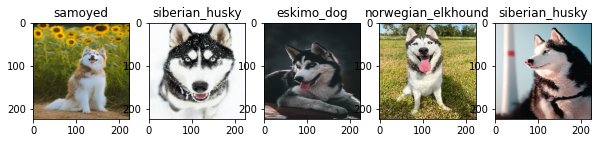

In [ ]:
#Checking custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)